## Library

In [1]:
# import packages: numpy, math (you might need pi for gaussian functions)
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2

## Gauss Module

In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from scipy.ndimage import convolve1d as conv
from PIL import Image

"""
Gaussian function taking as argument the standard deviation sigma
The filter should be defined for all integer values x in the range [-3sigma,3sigma]
The function should return the Gaussian values Gx computed at the indexes x
"""

def get_half_width(sigma):
    return round(3*sigma - 0.5)


def gauss(sigma):
    
    # w_hat = get_half_width(sigma)
    # w = 2*(w_hat) + 1
    # sums = 0 
    # Gx = []

    # for i in range(w):
    #     Gx.append(np.exp(-(i - w_hat) * (i - w_hat)/(2*sigma**2)))
    #     sums = sums + Gx[i]  
    # for i in range(w):
    #     Gx[i] = Gx[i] / sums
        
    # x = np.arange(int(-3*sigma),int(3*sigma) + 1, 1)
    
    # start -> lower limit  of the interval
    # end -> upper limit of the interval
    # interval -> is the steps in the interval
    start = int(-3*sigma)
    end = int(3*sigma)
    interval = 1
    
    # we then convert the list to a numpy array 
    x = np.array(range(start, end +1, interval))
    
    Gx = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-x**2/(2*sigma**2))
        
    return Gx, x



"""
Implement a 2D Gaussian filter, leveraging the previous gauss.
Implement the filter from scratch or leverage the convolve2D method (scipy.signal)
Leverage the separability of Gaussian filtering
Input: image, sigma (standard deviation)
Output: smoothed image
"""
def gaussianfilter(img, sigma):
        
    # convolved2d takes as input a 2D (greyscale) array not RGB
    

    Gx, x = gauss(sigma)

    # since the gaussian filter is separable
    # (Fx convolved Fy) convolved I = Fx convolved (Fy convolved I)
    
    # Create 2 distinct filters from the gaussian. One horizontal and one vertical
    Fy = np.reshape(Gx, (1, x.size)) # for example if sigma = 4 =====> H = (1,25)
    Fx = np.reshape(Gx, (x.size, 1))   #                        =====> V = (25,1)

    
    # we first convolve each row with a 1D - filter
    first_convo = conv2(img, Fy, mode='same', boundary='fill') 

    # then convolve each column with a 1D - filter
    smooth_img = conv2(first_convo, Fx, mode='same', boundary='fill')


    #smooth_img = Image.fromarray(smooth_img) # reconvert image to RGB (otherwise the image will be green...)


    return smooth_img



"""
Gaussian derivative function taking as argument the standard deviation sigma
The filter should be defined for all integer values x in the range [-3sigma,3sigma]
The function should return the Gaussian derivative values Dx computed at the indexes x
"""
def gaussdx(sigma):
    
    # start -> lower limit  of the interval
    # end -> upper limit of the interval
    # interval -> is the steps in the interval
    start = int(-3*sigma)
    end = int(3*sigma)
    interval = 1
    
    # we then convert the list to a numpy array 
    x = np.array(range(start, end +1 , interval))
    
    Dx = -1/(np.sqrt(2*np.pi)*sigma**3)*x*np.exp(-x**2/(2*sigma**2))
    
    return Dx, x



def gaussderiv(img, sigma):
    
    sigma = int(sigma)

    img = gaussianfilter(img, sigma)

    Dx, x = gaussdx(sigma)
    
    # def func(x):
    #     return np.convolve(x, Dx, "same")
        
    
    #imgDx=np.apply_along_axis(func,axis=0, arr=img) #apply to all rows
    #imgDy=np.apply_along_axis(func,axis=1, arr=img) #apply to all columns  
    imgDx = conv(img, Dx, axis=1)
    imgDy = conv(img, Dx, axis=0)
    return imgDx, imgDy

## Histogram

In [15]:
import numpy as np
from numpy import histogram as hist
from PIL import Image


#Add the Filtering folder, to import the gauss_module.py file, where gaussderiv is defined (needed for dxdy_hist)
import sys, os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
filteringpath = os.path.join(parentdir, 'Filtering')
sys.path.insert(0,filteringpath)




#  compute histogram of image intensities, histogram should be normalized so that sum of all values equals 1
#  assume that image intensity varies between 0 and 255
#
#  img_gray - input image in grayscale format
#  num_bins - number of bins in the histogram

def normalized_hist(img_gray, num_bins):
    
    assert len(img_gray.shape) == 2, 'image dimension mismatch'
    assert img_gray.dtype == 'float', 'incorrect image type'


    steps = 255/num_bins
    bins = np.arange(0, 255, steps)
    
    # steps could have not reached 255, we should check
    if bins[-1] != 255: # if TRUE we append 255 as the last upper limit of the last bin 
        bins = np.append(bins, np.array([255]))
    
    # we could implement a Binary Search for this task/ List comprehension
    hists = [0] * len(bins)
    
    # For each row
    for pixel in img_gray:
        # for each pixel in that row
        for p in pixel:
            # for each bin we check the upper limit
            for index, b in enumerate(bins):
                
                # if pixel is smaller or the same to the upper limit of the bin then we add one to the final bin
                if p<=b:
                    hists[index] +=1
                    break 
    # The initial bin starts at 0 and ends and 0, that is why we delete it
    hists.pop(0)
    hists = np.array(hists)     

    # We normalize the histogram so that the sum of the values is equal to one
    n_pixels = img_gray.shape[0]*img_gray.shape[1]
    hists = hists / n_pixels
            
    
    return hists, bins


#  Compute the *joint* histogram for each color channel in the image
#  The histogram should be normalized so that sum of all values equals 1
#  Assume that values in each channel vary between 0 and 255
#
#  img_color - input color image
#  num_bins - number of bins used to discretize each channel, total number of bins in the histogram should be num_bins^3
#
#  E.g. hists[0,9,5] contains the number of image_color pixels such that:
#       - their R values fall in bin 0
#       - their G values fall in bin 9
#       - their B values fall in bin 5
def rgb_hist(img_color_double, num_bins):
    assert len(img_color_double.shape) == 3, 'image dimension mismatch'
    assert img_color_double.dtype == 'float', 'incorrect image type'

    

    #Define a 3D histogram  with "num_bins^3" number of entries
    hists = np.zeros((num_bins, num_bins, num_bins))
    # The bin size is:
    bin_size = 255 / num_bins
    
    # Now, we should create three arrays (RED, GREEN, BLUE), for each pixel in the image
    img_color_double_flatten = img_color_double.flatten()
    red = img_color_double_flatten[::3]
    green = img_color_double_flatten[1::3]
    blue = img_color_double_flatten[2::3]
    
    
    # At this point we have three arrays of dimension 1 x n.pixels
    # we should insert each pixel in one particular bin, we can do this by dividing each value by n.bins
    red_bin = (red/bin_size).astype(int)
    green_bin = (green/bin_size).astype(int)
    blue_bin = (blue/bin_size).astype(int)
    
    
    
    # Loop for each pixel i in the image = n. rows * n.col
    n_pixels = len(img_color_double)*len(img_color_double[0])
    
    for i in range(n_pixels):

        # Increment the histogram bin which corresponds to the R,G,B value of the pixel i
        hists[red_bin[i], green_bin[i], blue_bin[i]] += 1

        pass


    #Normalize the histogram such that its integral (sum) is equal 1
    hists = hists / n_pixels

    #Return the histogram as a 1D vector
    hists = hists.reshape(hists.size)
    
    return hists



#  Compute the *joint* histogram for the R and G color channels in the image
#  The histogram should be normalized so that sum of all values equals 1
#  Assume that values in each channel vary between 0 and 255
#
#  img_color - input color image
#  num_bins - number of bins used to discretize each channel, total number of bins in the histogram should be num_bins^2
#
#  E.g. hists[0,9] contains the number of image_color pixels such that:
#       - their R values fall in bin 0
#       - their G values fall in bin 9
def rg_hist(img_color_double, num_bins ):
    assert len(img_color_double.shape) == 3, 'image dimension mismatch'
    assert img_color_double.dtype == 'float', 'incorrect image type'
    
    
    #Define a 2D histogram  with "num_bins^2" number of entries
    hists = np.zeros((num_bins, num_bins))
    
    # The bin size is:
    bin_size = 255 / num_bins
    
    # Now, we should create two arrays (RED, GREEN), for each pixel in the image
    # let's keep only red and green values
    img_color_double_flatten = img_color_double.flatten()
    red = img_color_double_flatten[::3]
    green = img_color_double_flatten[1::3]
    
    # At this point we have two arrays of dimension 1 x n.pixels
    # we should insert each pixel in one particular bin, we can do this by dividing each value by n.bins
    red_bin = (red/bin_size).astype(int)
    green_bin = (green/bin_size).astype(int)
    
    
    # Loop for each pixel i in the image = n. rows * n.col
    n_pixels = len(img_color_double)*len(img_color_double[0])
    
    for i in range(n_pixels):

        # Increment the histogram bin which corresponds to the R,G value of the pixel i
        hists[red_bin[i], green_bin[i]] += 1

        pass


    #Normalize the histogram such that its integral (sum) is equal 1
    hists = hists / n_pixels

    #Return the histogram as a 1D vector
    hists = hists.reshape(hists.size)
    
    return hists
    


#  Compute the *joint* histogram of Gaussian partial derivatives of the image in x and y direction
#  Set sigma to 3.0 and cap the range of derivative values is in the range [-6, 6]
#  The histogram should be normalized so that sum of all values equals 1
#
#  img_gray - input gray value image
#  num_bins - number of bins used to discretize each dimension, total number of bins in the histogram should be num_bins^2
#
#  Note: you may use the function gaussderiv from the Filtering exercise (gauss_module.py)

def dxdy_hist(img_gray, num_bins):
    assert len(img_gray.shape) == 2, 'image dimension mismatch'
    assert img_gray.dtype == 'float', 'incorrect image type'
    
    
    min_interval = -6
    max_interval = 6
    
    # defining the x and y derivatives of the image and
    # defining the minimum and maximum range of the derivatives
    derivx, derivy = gaussderiv(img_gray, 3)
    derivx = np.clip(derivx, min_interval, max_interval)
    derivy = np.clip(derivy, min_interval, max_interval) 
    
    # stacking the derivatives to iterate over them
    stacked = list(zip(derivx.reshape(-1), derivy.reshape(-1)))

    # the bin size is equal to the difference of the extremes
    # divided by the input number of bins    
    bin_size = (max_interval - min_interval)/num_bins
    
    # filling the list's values with the equal-distanced bins
    bins = [min_interval for _ in range(num_bins+1)]
    previous = min_interval
    for i in range(num_bins):
        bin_ = previous + bin_size
        bins[i+1] = bin_
        previous = bin_

    # defining a 2D histogram  with "num_bins^2" number of entries
    hists = np.zeros((num_bins, num_bins))
    
    # filling the array's values with the frequencies of the 
    # pixels in the bins intervals
    for i in range(len(stacked)):

        deriv_xy = [0,0]
        for k in range(len(bins)):
            if bins[k-1] <= stacked[i][0] < bins[k]:
                deriv_xy[0] = k-1
            if bins[k-1] <= stacked[i][1] < bins[k]:
                deriv_xy[1] = k-1
                    
        hists[deriv_xy[0],deriv_xy[1]] += 1
    
    hists = hists/np.sum(hists)
    # return the histogram as a 1D vector
    hists = hists.reshape(hists.size)
    return hists


def is_grayvalue_hist(hist_name):
    if hist_name == 'grayvalue' or hist_name == 'dxdy':
        return True
    elif hist_name == 'rgb' or hist_name == 'rg':
        return False
    else:
        assert False, 'unknown histogram type'


def get_hist_by_name(img, num_bins_gray, hist_name):
    if hist_name == 'grayvalue':
        return normalized_hist(img, num_bins_gray)
    elif hist_name == 'rgb':
        return rgb_hist(img, num_bins_gray)
    elif hist_name == 'rg':
        return rg_hist(img, num_bins_gray)
    elif hist_name == 'dxdy':
        return dxdy_hist(img, num_bins_gray)
    else:
        assert False, 'unknown distance: %s'%hist_name

## Distance

In [26]:
# Compute the intersection distance between histograms x and y
# Return 1 - hist_intersection, so smaller values correspond to more similar histograms
# Check that the distance range in [0,1]

def dist_intersect(x,y):
    
    # First part of the formula is sum(minimum(x_i, y_i)) for each i 
    min_intersection = np.minimum(x, y)
    
    
    # To normalize the result we should divide it by the number of total values of an histogram
    # Since we know that the size is the same for every image, it doesn't matter which one we pick
    intersection = np.true_divide(np.sum(min_intersection), np.sum(x))
    complement_intersection = 1-intersection

    # Check that everything works:
    if 0 <= complement_intersection <= 1:
        return complement_intersection
    else:
        print('An error has occured')



# Compute the L2 distance between x and y histograms
# Check that the distance range in [0,sqrt(2)]

def dist_l2(x,y):
    
    
    
    # L2 distance or Euclidean distance is measured by computing the sum of 
    # squared difference of the two arrays
    l2_list = np.square(x - y)
    l2 = np.sum(l2_list)
    
    # Check that everything works:
    if 0 <= l2 <= math.sqrt(2):
        return l2
    else:
        print('An error has occured')
    


# Compute chi2 distance between x and y
# Check that the distance range in [0,Inf]
# Add a minimum score to each cell of the histograms (e.g. 1) to avoid division by 0

def dist_chi2(x,y):
    
    # First of all we compute the divisor for each value 
    div = ((x +1) + (y+1))
    
    # if divisor_i is equal to 0 change with 1 in order to perform division and avoid division by 0
    
    # After we compute the numerator of the equation, essentially it's the l2 distance
    chi2_num = np.square((x+1) - (y+1))
    
    # We divide the numerator by the denominator that we previously computed
    chi2_list = np.divide(chi2_num, div)
    chi2 = np.sum(chi2_list)
    # Check that everything works:
        
    
    if 0 <= chi2 <= math.inf:
        return chi2
    else:
        print('An error has occured')


def get_dist_by_name(x, y, dist_name):
    if dist_name == 'chi2':
        return dist_chi2(x,y)
    elif dist_name == 'intersect':
        return dist_intersect(x,y)
    elif dist_name == 'l2':
        return dist_l2(x,y)
    else:
        assert False, 'unknown distance: %s'%dist_name
  

## Match module

In [27]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray



# model_images - list of file names of model images
# query_images - list of file names of query images
#
# dist_type - string which specifies distance type:  'chi2', 'l2', 'intersect'
# hist_type - string which specifies histogram type:  'grayvalue', 'dxdy', 'rgb', 'rg'
#
# note: use functions 'get_dist_by_name', 'get_hist_by_name' and 'is_grayvalue_hist' to obtain 
#       handles to distance and histogram functions, and to find out whether histogram function 
#       expects grayvalue or color image


def find_best_match(model_images, query_images, dist_type, hist_type, num_bins):

    # whether histogram function expects grayvalue or color image
    hist_isgray = is_grayvalue_hist(hist_type)

    # form list of file images to list of histograms
    model_hists = compute_histograms(model_images, hist_type, hist_isgray, num_bins)
    query_hists = compute_histograms(query_images, hist_type, hist_isgray, num_bins)

    D = np.zeros((len(model_images), len(query_images))) # container for distances
    best_match = [] # container for best match for each image

    for i in range(len(query_images)):
        Q = query_hists[i]
        for j in range(len(model_hists)):
            V = model_hists[j]
            h1 = Q.copy()
            h2 = V.copy()
            dist = get_dist_by_name(h1, h2, dist_type) # distance between histogram
            D[j, i] = dist # save distance measure in correct position
        idx = list(D[:, i]).index(min(D[:, i])) # find histogram with lower distance respect to the one in exam
        best_match.append(idx)

    return np.array(best_match), D


def compute_histograms(image_list, hist_type, hist_isgray, num_bins):
    
    image_hist = []

    #We compute the histogram value for every image and we append it to our image_hist list

    for i in range(len(image_list)):
        img = np.array(Image.open(image_list[i]))
        img = img.astype('double')
        if hist_isgray:
            img = rgb2gray(img)
        hist = get_hist_by_name(img, num_bins, hist_type)
 
        if len(hist) == 2:
             hist = hist[0]
 
        image_hist.append(hist)

    return image_hist



# For each image file from 'query_images' find and visualize the 5 nearest images from 'model_image'.
#
# Note: use the previously implemented function 'find_best_match'
# Note: use subplot command to show all the images in the same Python figure, one row per query image

def show_neighbors(model_images, query_images, dist_type, hist_type, num_bins):
    
    
    plt.figure()

    num_nearest = 5  # show the top-5 neighbors
    
    best_match, D = find_best_match(model_images, query_images, dist_type, hist_type, num_bins)
    for i in range(len(query_images)):

        #We sort the images according to the best_match function retrieving the num_nearest closest
        closest_images = sorted(range(len(D[:, i])), key=lambda k: D[:, i][k])[:num_nearest]

        #We construct the plot
        for j in range(1, num_nearest+2):

           
            plt.figure(num_nearest+1, figsize=(50, 50))
            #We want to show the closest images in the same row
            ax = plt.subplot(1, num_nearest+1, j)
            ax.title.set_size(40)
            plt.axis('off')

            if j == 1: #The query image
                ax.title.set_text('Q'+str(i))
                plt.imshow(np.array(Image.open(query_images[i])))
            else: #The closest images that we found
                
                ax.title.set_text('M'+str(round(D[closest_images[j-2], i], 2)))
                plt.imshow(np.array(Image.open(model_images[closest_images[j-2]])))
        plt.show()

    return


## Exericise 2

In [28]:
'''## gray-value histograms (Question 2.a)

img_color = np.array(Image.open('./model/obj100__0.png'))
img_gray = rgb2gray(img_color.astype('double'))

plt.figure(1)
plt.subplot(1,3,1)
plt.imshow(img_color)

plt.subplot(1,3,2)
num_bins_gray = 40
hist_gray1, bin_gray1 = hist(img_gray.reshape(img_gray.size), num_bins_gray,(0,255))
plt.bar((bin_gray1[0:-1] + bin_gray1[1:])/2, hist_gray1)

plt.subplot(1,3,3)
hist_gray2, bin_gray2 = normalized_hist(img_gray, num_bins_gray)
plt.bar((bin_gray2[0:-1] + bin_gray2[1:])/2, hist_gray2)
plt.tight_layout()



## more histograms (Question 2.b)

#Compose and test RGB histograms (rgb_hist)
plt.figure(2)
plt.subplot(1,2,1)
plt.imshow(img_color)

num_bins_color = 5
plt.subplot(1,2,2)
hist_rgb = rgb_hist(img_color.astype('double'), num_bins_color)
plt.bar(np.array(range(1,hist_rgb.size+1)),hist_rgb)
plt.show()

#Compose and test RG histograms (rg_hist)
plt.figure(3)
plt.subplot(1,2,1)
plt.imshow(img_color)

num_bins_color = 5
plt.subplot(1,2,2)
hist_rg = rg_hist(img_color.astype('double'), num_bins_color)
plt.bar(np.array(range(1,hist_rg.size+1)),hist_rg)
plt.show()


#Compose and test dxdy histograms (dxdy_hist)

plt.figure(5)
plt.subplot(1,2,1)
plt.imshow(img_color)

num_bins_dxdy = 10
plt.subplot(1,2,2)

hist_dxdy = dxdy_hist(img_gray, num_bins_dxdy)
plt.bar(np.array(range(1,hist_dxdy.size+1)),hist_dxdy)
plt.show()


# %%
## Distance functions (Question 2.c)

image_files1 = ['./model/obj1__0.png']
image_files2 = ['./model/obj91__0.png', './model/obj94__0.png']

plt.figure()
plt.subplot(1,3,1); plt.imshow(np.array(Image.open(image_files1[0])), vmin=0, vmax=255); plt.title(image_files1[0])
plt.subplot(1,3,2); plt.imshow(np.array(Image.open(image_files2[0])), vmin=0, vmax=255); plt.title(image_files2[0])
plt.subplot(1,3,3); plt.imshow(np.array(Image.open(image_files2[1])), vmin=0, vmax=255); plt.title(image_files2[1])
plt.show()

img1_color = np.array(Image.open(image_files1[0]))
img2_color = np.array(Image.open(image_files2[0]))
num_bins_color = 30
hist1_rgb = rgb_hist(img1_color.astype('double'), num_bins_color)
hist2_rgb = rgb_hist(img2_color.astype('double'), num_bins_color)

print('Distance according to dist_l2 %f'% dist_l2(hist1_rgb,hist2_rgb))
print('Distance according to dist_interset %f'% dist_intersect(hist1_rgb,hist2_rgb))
print('Distance according to dist_chi2 %f'% dist_chi2(hist1_rgb,hist2_rgb))


distance_types = ['l2', 'intersect', 'chi2']
print('distance functions:', distance_types)

hist_types = ['grayvalue', 'rgb', 'rg', 'dxdy']
print('histogram types:', hist_types)

num_bins_color = 30;
num_bins_gray = 90;
'''

"## gray-value histograms (Question 2.a)\n\nimg_color = np.array(Image.open('./model/obj100__0.png'))\nimg_gray = rgb2gray(img_color.astype('double'))\n\nplt.figure(1)\nplt.subplot(1,3,1)\nplt.imshow(img_color)\n\nplt.subplot(1,3,2)\nnum_bins_gray = 40\nhist_gray1, bin_gray1 = hist(img_gray.reshape(img_gray.size), num_bins_gray,(0,255))\nplt.bar((bin_gray1[0:-1] + bin_gray1[1:])/2, hist_gray1)\n\nplt.subplot(1,3,3)\nhist_gray2, bin_gray2 = normalized_hist(img_gray, num_bins_gray)\nplt.bar((bin_gray2[0:-1] + bin_gray2[1:])/2, hist_gray2)\nplt.tight_layout()\n\n\n\n## more histograms (Question 2.b)\n\n#Compose and test RGB histograms (rgb_hist)\nplt.figure(2)\nplt.subplot(1,2,1)\nplt.imshow(img_color)\n\nnum_bins_color = 5\nplt.subplot(1,2,2)\nhist_rgb = rgb_hist(img_color.astype('double'), num_bins_color)\nplt.bar(np.array(range(1,hist_rgb.size+1)),hist_rgb)\nplt.show()\n\n#Compose and test RG histograms (rg_hist)\nplt.figure(3)\nplt.subplot(1,2,1)\nplt.imshow(img_color)\n\nnum_bins_col

----

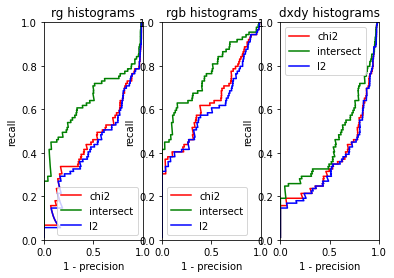

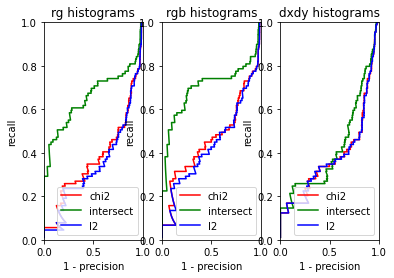

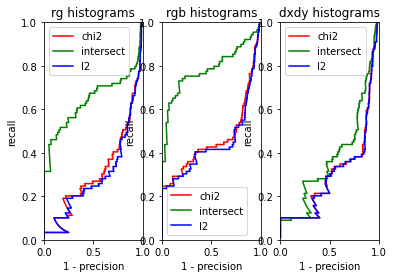

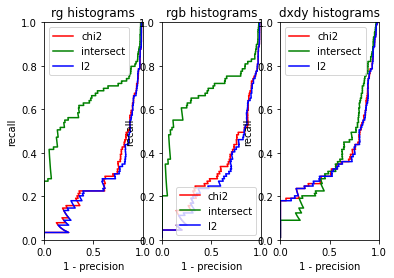

In [30]:
# compute and plot the recall/precision curve
#
# D - square matrix, D(i, j) = distance between model image i, and query image j
#
# note: assume that query and model images are in the same order, i.e. correct answer for i-th query image is the i-th model image

with open('/Users/yves/Desktop/Data_Science/second_year/AML/Assignment1/Identification/model.txt') as fp:
    model_images = fp.readlines()
model_images = ['/Users/yves/Desktop/Data_Science/second_year/AML/Assignment1/Identification/'+x.strip() for x in model_images] 
#print(len(model_images))

with open('/Users/yves/Desktop/Data_Science/second_year/AML/Assignment1/Identification/query.txt') as fp:
    query_images = fp.readlines()
query_images = ['/Users/yves/Desktop/Data_Science/second_year/AML/Assignment1/Identification/'+x.strip() for x in query_images] 
#print(len(query_images))


def plot_rpc(D, plot_color):
    
    recall = []
    precision = []

    num_queries = D.shape[1]   # number of images in query
    num_images = D.shape[0]  # number of images in model

    assert(num_images == num_queries), 'Distance matrix should be a square matrix'
    
    labels = np.diag([1]*num_images)
    
    d = D.reshape(D.size)  # flatten distance matrix
    l = labels.reshape(labels.size)  # flatten labels
     
    sortidx = d.argsort()   # sorted distance matrix indexes
    d = d[sortidx]  # sorted flatten distance matrix 
    l = l[sortidx]  # sorted flatten labels 
    
    tp = 0
    
    for idt in range(len(d)):
        
        tp += l[idt]
        
        
        
        #Compute precision and recall values and append them to "recall" and "precision" vectors
        
        precision.append(tp/ (idt + 1))
        recall.append(tp/num_images)
    
    

    plt.plot([1-precision[i] for i in range(len(precision))], recall, plot_color+'-')



def compare_dist_rpc(model_images, query_images, dist_types, hist_type, num_bins, plot_colors):
    
    assert len(plot_colors) == len(dist_types), 'number of distance types should match the requested plot colors'

    for idx in range( len(dist_types) ):

        [best_match, D] = find_best_match(model_images, query_images, dist_types[idx], hist_type, num_bins)

        plot_rpc(D, plot_colors[idx])
    

    plt.axis([0, 1, 0, 1]);
    plt.xlabel('1 - precision');
    plt.ylabel('recall');
    
    # legend(dist_types, 'Location', 'Best')
    
    plt.legend( dist_types, loc='best')


#plt.figure(1, figsize=(15,10))

dist_type = ['chi2', 'intersect', 'l2']
hist_model = ['rg', 'rgb', 'dxdy']
Binss = [10, 20 , 30, 40]
for bins in Binss:
    cols = ['r', 'g', 'b']
    for i in range(1,4):
        plt.subplot(1,3,i)
        if i != 2:
            compare_dist_rpc(model_images, query_images, dist_type, hist_model[i-1], bins, cols)
            plt.title(hist_model[i-1] + ' histograms')
        else:
            compare_dist_rpc(model_images, query_images, dist_type, hist_model[i-1], bins // 2, cols)
            plt.title(hist_model[i-1] + ' histograms')
    plt.savefig("hist_bins"+str(bins)+".png", format='png', dpi=600)
    plt.show()



## Grid search

In [31]:
import pandas as pd
from itertools import product 
import os

In [32]:
directory_1 = '/Users/yves/Desktop/ADVANCE-MACHINE-LEARNING/HW 1/Identification/model'
model_list = []
for filename in os.listdir(directory_1):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        model_list += [os.path.join(filename)]
    else:
        continue

In [33]:
directory_2 = '/Users/yves/Desktop/ADVANCE-MACHINE-LEARNING/HW 1/Identification/query'
query_list = []
for filename in os.listdir(directory_2):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        query_list += [os.path.join(filename)]
    else:
        continue

In [34]:
model_images = [directory_1 + '/'+x for x in model_list]
query_images = [directory_2 + '/'+x for x in query_list]

In [35]:
with open('/Users/yves/Desktop/ADVANCE-MACHINE-LEARNING/HW 1/Identification/model.txt') as fp:
    model_images = fp.readlines()
model_images = [x.strip() for x in model_images] 

with open('/Users/yves/Desktop/ADVANCE-MACHINE-LEARNING/HW 1/Identification/query.txt') as fp:
    query_images = fp.readlines()
query_images = [x.strip() for x in query_images]

model_images = ['/Users/yves/Desktop/ADVANCE-MACHINE-LEARNING/HW 1/Identification/'+x for x in model_images]
query_images = ['/Users/yves/Desktop/ADVANCE-MACHINE-LEARNING/HW 1/Identification/'+x for x in query_images]

In [36]:
def grid_search(model_images, query_images, dist_type, hist_type, num_bins):
    
    #match_module.

    [best_match, D] = find_best_match(model_images, query_images, dist_type, hist_type, num_bins)

    num_correct = sum(best_match == range(len(query_images)))
    recog_rate = num_correct / len(query_images)

    return [dist_type, hist_type, num_bins, num_correct, recog_rate]

In [40]:
dist_list = ['chi2', 'l2','intersect']
hist_list = ['grayvalue', 'rgb', 'rg','dxdy']
num_bins = [10, 20 , 30, 40]

In [41]:
parameters = list(product(dist_list,hist_list,num_bins))

In [42]:
results = []
for i in range(len(parameters)):
    results += [grid_search(model_images, query_images,parameters[i][0],parameters[i][1],parameters[i][2])]

In [43]:
results

[['chi2', 'grayvalue', 10, 41, 0.4606741573033708],
 ['chi2', 'grayvalue', 20, 35, 0.39325842696629215],
 ['chi2', 'grayvalue', 30, 36, 0.4044943820224719],
 ['chi2', 'grayvalue', 40, 34, 0.38202247191011235],
 ['chi2', 'rgb', 10, 59, 0.6629213483146067],
 ['chi2', 'rgb', 20, 46, 0.5168539325842697],
 ['chi2', 'rgb', 30, 36, 0.4044943820224719],
 ['chi2', 'rgb', 40, 31, 0.34831460674157305],
 ['chi2', 'rg', 10, 52, 0.5842696629213483],
 ['chi2', 'rg', 20, 48, 0.5393258426966292],
 ['chi2', 'rg', 30, 41, 0.4606741573033708],
 ['chi2', 'rg', 40, 37, 0.4157303370786517],
 ['chi2', 'dxdy', 10, 43, 0.48314606741573035],
 ['chi2', 'dxdy', 20, 42, 0.47191011235955055],
 ['chi2', 'dxdy', 30, 43, 0.48314606741573035],
 ['chi2', 'dxdy', 40, 44, 0.4943820224719101],
 ['l2', 'grayvalue', 10, 39, 0.43820224719101125],
 ['l2', 'grayvalue', 20, 34, 0.38202247191011235],
 ['l2', 'grayvalue', 30, 36, 0.4044943820224719],
 ['l2', 'grayvalue', 40, 34, 0.38202247191011235],
 ['l2', 'rgb', 10, 54, 0.606741

In [44]:
df = pd.DataFrame(results)

In [45]:
df.columns = ['dist_type', 'hist_type', 'num_bins','correct','recog_rate'] 

In [46]:
df

,dist_type,hist_type,num_bins,correct,recog_rate
0,chi2,grayvalue,10,41,0.460674
1,chi2,grayvalue,20,35,0.393258
2,chi2,grayvalue,30,36,0.404494
3,chi2,grayvalue,40,34,0.382022
4,chi2,rgb,10,59,0.662921
5,chi2,rgb,20,46,0.516854
6,chi2,rgb,30,36,0.404494
7,chi2,rgb,40,31,0.348315
8,chi2,rg,10,52,0.584270
9,chi2,rg,20,48,0.539326


In [47]:
df.to_csv(r'I+PAZZI_DI_GITHUB.csv', index = False)

In [63]:
df.groupby(['num_bins'], sort=False)['recog_rate'].mean()

num_bins
10    0.573034
20    0.531835
30    0.509363
40    0.498127
Name: recog_rate, dtype: float64

In [49]:
df.groupby(['dist_type'], sort=False)['recog_rate'].max()

dist_type
chi2         0.662921
l2           0.606742
intersect    0.808989
Name: recog_rate, dtype: float64

In [50]:
df.groupby(['dist_type'], sort=False)['recog_rate'].min()

dist_type
chi2         0.348315
l2           0.337079
intersect    0.505618
Name: recog_rate, dtype: float64

In [51]:
df.groupby(['hist_type'], sort=False)['recog_rate'].min()

hist_type
grayvalue    0.382022
rgb          0.337079
rg           0.415730
dxdy         0.471910
Name: recog_rate, dtype: float64

In [61]:
df.sort_values('recog_rate', ascending=False).head(10)

,dist_type,hist_type,num_bins,correct,recog_rate
38,intersect,rgb,30,72,0.808989
37,intersect,rgb,20,71,0.797753
39,intersect,rgb,40,70,0.786517
36,intersect,rgb,10,70,0.786517
43,intersect,rg,40,67,0.752809
42,intersect,rg,30,65,0.730337
41,intersect,rg,20,65,0.730337
40,intersect,rg,10,62,0.696629
4,chi2,rgb,10,59,0.662921
47,intersect,dxdy,40,58,0.651685


In [62]:
df.sort_values('recog_rate', ascending=False).tail(10)

,dist_type,hist_type,num_bins,correct,recog_rate
18,l2,grayvalue,30,36,0.404494
6,chi2,rgb,30,36,0.404494
2,chi2,grayvalue,30,36,0.404494
1,chi2,grayvalue,20,35,0.393258
22,l2,rgb,30,34,0.382022
19,l2,grayvalue,40,34,0.382022
17,l2,grayvalue,20,34,0.382022
3,chi2,grayvalue,40,34,0.382022
7,chi2,rgb,40,31,0.348315
23,l2,rgb,40,30,0.337079
